# Model finding (Bagging)

This notebook will work finding the best model to make predictions on our datas 

**Main goals are**: 
- Optimize predictions by aggregating models

In [1]:
# Retreiving a significative amount of data
from local_lib.dataset import retreiveDatasetFromCsv

dataset = retreiveDatasetFromCsv(src="../../datasets/chest_Xray/_processed_resize_small/_processed_dfs")
dataset = dataset.sample(frac=1, random_state=42)

In [2]:
dataset.iloc[0]["pixel_value"]

array([ 31,  37,  63, ..., 202, 204, 207], dtype=int64)

**We use a custom flatten mask to make our data compatible with machine learning models**

In [2]:
from local_lib.flatten_transformer import FlattenTransformer
from sklearn.pipeline import Pipeline
import numpy as np

pipeline = Pipeline([
    ('image_mask', FlattenTransformer()),
])

# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))

In [5]:
import numpy as np
np.shape(X)

(5856, 20130)

In [6]:
np.unique(y)

array([0, 1, 2])

### Now we try to extend to 3 classes

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [5]:
# First of all we will use a DummyClassifier to get an idea of what a uncorrelated model looks like
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
ac = dummy_clf.score(X_test, y_test)
print("Using randomly generated answer we get " + str(ac) + "% Accuracy")

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
ac = round(dummy_clf.score(X_test, y_test) * 100, 2)
print("Using only most frequent number as answer we get " + str(ac) + "% Accuracy")

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
ac = round(dummy_clf.score(X_test, y_test) * 100, 2)
print("Using uniform distribution answer we get " + str(ac) + "% Accuracy")

Using randomly generated answer we get 0.3616140713916192% Accuracy
Using only most frequent number as answer we get 47.9% Accuracy
Using uniform distribution answer we get 33.26% Accuracy


### We display base performance of model

Test Accuracy: 0.71
Test Precision: 0.74
Test Recall: 0.71
Confusion matrix:



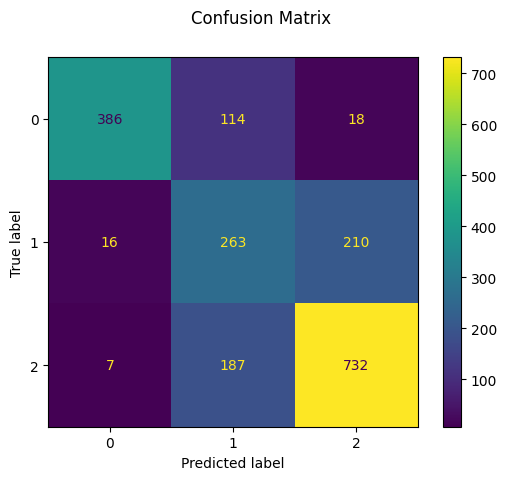

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import  GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, accuracy_score


pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
y_pred_simpler = pipeline.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_simpler)
test_precision = precision_score(y_test, y_pred_simpler, average="weighted")
test_recall = recall_score(y_test, y_pred_simpler, average="weighted")

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix")

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

print(f"Confusion matrix:\n")
plt.show()

**We will create a pool of model to combine predictions**

**Voting classifier** is a good starting point to see what mask and scaler can bring to each other

In [13]:
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

knn_combined = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_geo = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="geometry")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_seuil = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="baseline")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_sample = Pipeline([
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_sample_minmax = Pipeline([
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
knn_sample_standard = Pipeline([
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
knn_combined_minmax = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
knn_combined_standard = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

eclf1 = VotingClassifier(estimators=[
    ('knn_combined', knn_combined),
    ('knn_geo', knn_geo),
    ('knn_seuil', knn_seuil),
    ('knn_sample', knn_sample),
    ('knn_sample_minmax', knn_sample_minmax),
    ('knn_sample_standard', knn_sample_standard),
    ('knn_combined_minmax', knn_combined_minmax),
    ('knn_combined_standard', knn_combined_standard)],
    voting='soft')

eclf1 = eclf1.fit(X_train, y_train)

y_pred_simpler = eclf1.predict(X_test)

train_accuracy = accuracy_score(y_test, y_pred_simpler)
train_precision = precision_score(y_test, y_pred_simpler, average="weighted")
train_recall = recall_score(y_test, y_pred_simpler, average="weighted")

In [14]:
print(f"Test Accuracy: {train_accuracy:.2f}")
print(f"Test Precision: {train_precision:.2f}")
print(f"Test Recall: {train_recall:.2f}")

Test Accuracy: 0.75
Test Precision: 0.76
Test Recall: 0.75


Test Accuracy: 0.75
Test Precision: 0.76
Test Recall: 0.75
Confusion matrix:



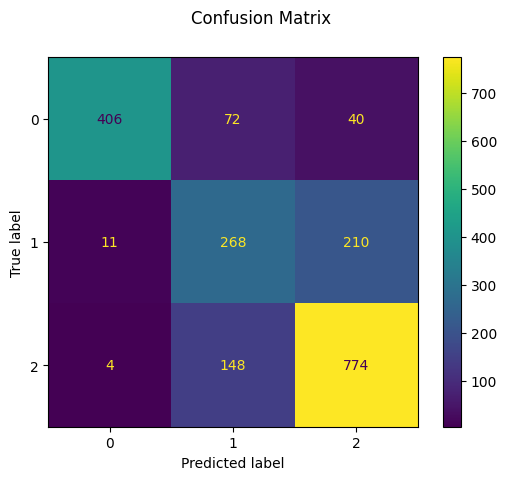

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import  GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, accuracy_score

y_pred_simpler = eclf1.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_simpler)
test_precision = precision_score(y_test, y_pred_simpler, average="weighted")
test_recall = recall_score(y_test, y_pred_simpler, average="weighted")

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix")

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

print(f"Confusion matrix:\n")
plt.show()

This simple aggregation helped us reaching better results

Now we will use more advanced aggregation techniques <br>
**Bagging classifier**

Test Accuracy: 0.71
Test Precision: 0.73
Test Recall: 0.71
Confusion matrix:



NameError: name 'plt' is not defined

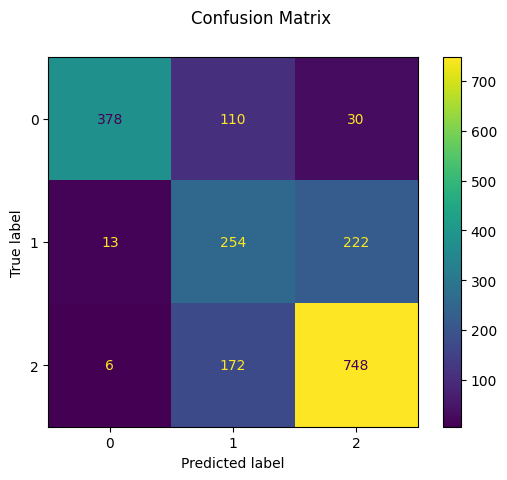

In [4]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

knn_combined = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])

clf = BaggingClassifier(estimator=knn_combined,
                        n_estimators=30, random_state=0).fit(X_train, y_train)

y_pred_simpler = clf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_simpler)
test_precision = precision_score(y_test, y_pred_simpler, average="weighted")
test_recall = recall_score(y_test, y_pred_simpler, average="weighted")

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix")

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

print(f"Confusion matrix:\n")
plt.show()

Not much improvments but way higher computation time

**Boosting**

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=10, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7485773409208484

Test Accuracy: 0.75
Test Precision: 0.75
Test Recall: 0.75
Confusion matrix:



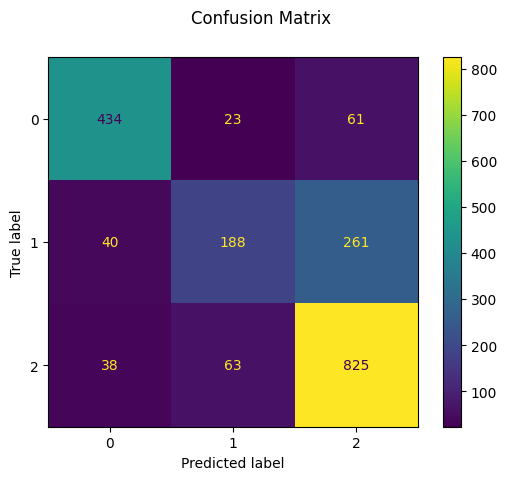

In [11]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_simpler = clf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_simpler)
test_precision = precision_score(y_test, y_pred_simpler, average="weighted")
test_recall = recall_score(y_test, y_pred_simpler, average="weighted")

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix")

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

print(f"Confusion matrix:\n")
plt.show()

Confusion on false negative increased wich we do not want to see

**Stacking**

Test Accuracy: 0.77
Test Precision: 0.76
Test Recall: 0.77
Confusion matrix:



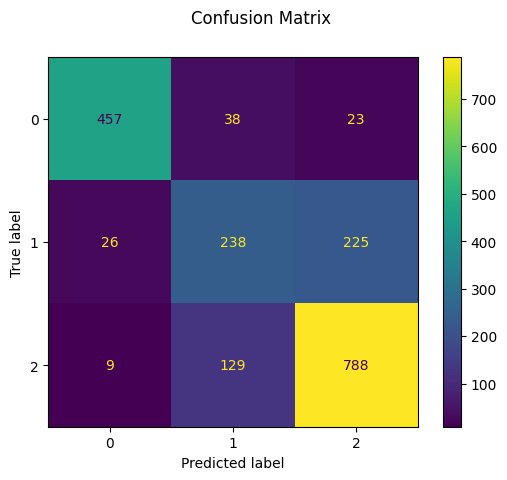

In [12]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

knn_combined = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_geo = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="geometry")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_seuil = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="baseline")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_sample = Pipeline([
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_sample_minmax = Pipeline([
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
knn_sample_standard = Pipeline([
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
knn_combined_minmax = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
knn_combined_standard = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

estimators = [
    ('knn_combined', knn_combined),
    ('knn_geo', knn_geo),
    ('knn_seuil', knn_seuil),
    ('knn_sample', knn_sample),
    ('knn_sample_minmax', knn_sample_minmax),
    ('knn_sample_standard', knn_sample_standard),
    ('knn_combined_minmax', knn_combined_minmax),
    ('knn_combined_standard', knn_combined_standard)
]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

clf.fit(X_train, y_train)
y_pred_simpler = clf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_simpler)
test_precision = precision_score(y_test, y_pred_simpler, average="weighted")
test_recall = recall_score(y_test, y_pred_simpler, average="weighted")

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix")

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

print(f"Confusion matrix:\n")
plt.show()

Really nice results with huge improvments on false positives but a bit of regression on false negative wich we would like to avoid

Trying with different final estimator

Test Accuracy: 0.74
Test Precision: 0.73
Test Recall: 0.74
Confusion matrix:



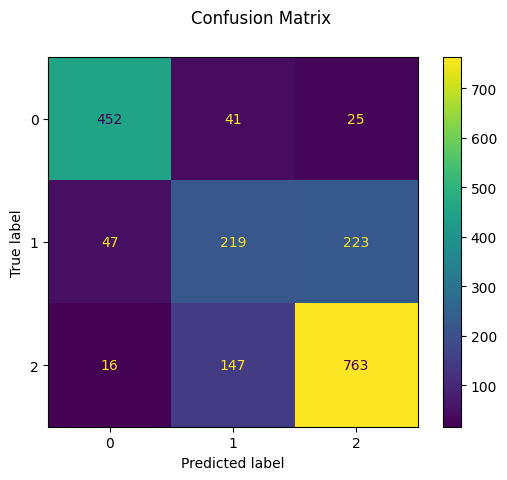

In [13]:
clf = StackingClassifier(
    estimators=estimators, final_estimator=KNeighborsClassifier()
)

clf.fit(X_train, y_train)
y_pred_simpler = clf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_simpler)
test_precision = precision_score(y_test, y_pred_simpler, average="weighted")
test_recall = recall_score(y_test, y_pred_simpler, average="weighted")

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix")

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

print(f"Confusion matrix:\n")
plt.show()